# Exploratory Data Analysis - Reddit data

### Libraries and PySpark Session

In [1]:
pip install spark-nlp==3.3.4

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#pip install numpy pandas nltk

In [8]:
from pyspark.sql import SparkSession

from pyspark.sql.types import *

In [5]:
spark = SparkSession.builder \
     .master('local[1]') \
     .appName('Reddit EDA') \
     .enableHiveSupport() \
     .getOrCreate()

spark.sparkContext.setLogLevel('ERROR')

In [6]:
from sparknlp.annotator import LemmatizerModel
import pyspark.sql.functions as f
from pyspark.sql import Window
import pyspark.sql.types as t
from pyspark.ml.feature import Tokenizer as pysparkTokenizer, HashingTF, StopWordsRemover, CountVectorizer
from pyspark.ml import Pipeline
from sparknlp.base import DocumentAssembler, Finisher
from sparknlp.annotator import Tokenizer, Normalizer, LemmatizerModel, StopWordsCleaner, PerceptronModel, Chunker
from pyspark.ml.feature import StopWordsRemover, CountVectorizer, IDF
from pyspark.ml.clustering import LDA
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

/opt/conda/miniconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bda_reddit_pw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Loading data

In [47]:
schema = StructType() \
    .add("id", IntegerType(), True) \
      .add("cryptocurrency",StringType(), True) \
      .add("title",StringType(),True) \
      .add("selftext",StringType(),True) \
      .add("created_utc",FloatType(),True) \
      .add("year",IntegerType(),True) \
      .add("month",IntegerType(),True) \
      .add("day",IntegerType(),True) \
      .add("hour",IntegerType(),True)

In [48]:
df_with_schema = spark.read.format("csv") \
      .option("header", True) \
      .schema(schema) \
      .load("historical_reddit_processed/csvData/")

In [39]:
df_with_schema.printSchema()

root
 |-- cryptocurrency: string (nullable = true)
 |-- title: string (nullable = true)
 |-- selftext: string (nullable = true)
 |-- created_utc: float (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)



# Overall data insights

In [40]:
df_with_schema.count()

28973

In [51]:
df2 = df_with_schema.select("cryptocurrency", "title", "selftext", f.concat_ws(" ", df_with_schema.title, df_with_schema.selftext).alias("text"))

In [49]:
data = df_with_schema.toPandas()

In [79]:
data.head(10)

,id,cryptocurrency,title,selftext,created_utc,year,month,day,hour
0,0,ethereum,Economics Of Public Goods,We provide over FREE on our D Link on our prof...,1.640996e+09,2022,1,1,0
1,1,bitcoin,When sovereign wealth funds,Anyone any news about this Any I think the s o...,1.640996e+09,2022,1,1,0
2,2,bitcoin,You have already won,I only have but I still feel early as I m the ...,1.640999e+09,2022,1,1,0
3,3,bitcoin,Good Android Wallet for,So I want to move away from Exodus and towards...,1.640999e+09,2022,1,1,1
4,4,ethereum,Seed phrase,Hi I have on word seed phrase but the are real...,1.640999e+09,2022,1,1,1
5,5,bitcoin,Seat tight and,ca faculty directory This guy publish one lame...,1.641000e+09,2022,1,1,1
6,6,dogecoin,Just bought doge coin,I spent on doge coin was this a good decision ...,1.641003e+09,2022,1,1,2
7,7,dogecoin,romance book to,I have about times in a k word manuscript It b...,1.641004e+09,2022,1,1,2
8,8,dogecoin,A challenge for the new year,A challenge for the new year Maybe it s your N...,1.641005e+09,2022,1,1,2
9,9,cardano,Is anyone working on a token,I think it d be pretty nifty to have a token t...,1.641005e+09,2022,1,1,2


# Popularity of cryptocurrency in reddit submissions - analysis

In [14]:
from pyspark.sql.functions import countDistinct

In [71]:
crypto_counts_pandas = df_with_schema.groupBy("cryptocurrency").agg(countDistinct('id')) \
    .toPandas()
crypto_counts_pandas.columns = ["cryptocurrency", "count"]

In [72]:
crypto_counts_pandas

,cryptocurrency,count
0,solana,2085
1,xrp,389
2,dogecoin,3259
3,bitcoin,4072
4,cardano,2690
5,ethereum,2331


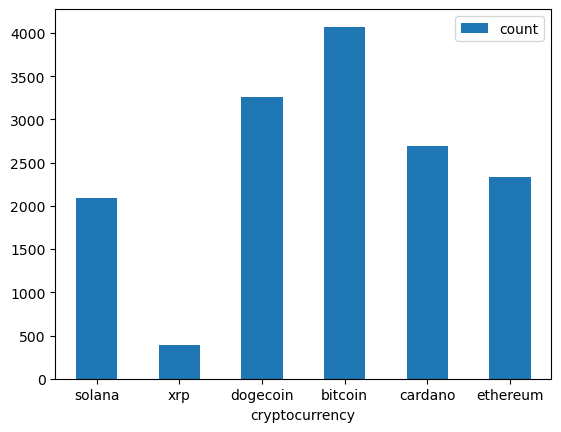

In [78]:
ax = crypto_counts_pandas.plot.bar(x='cryptocurrency', y='count', rot=0)


In [88]:
crypto_count_by_month = data.groupby(["cryptocurrency", "month"]).count().reset_index().loc[:,["cryptocurrency", "month", "id"]]

crypto_count_by_month.columns = ["cryptocurrency", "month", "count"]


In [90]:
import seaborn as sns
crypto_count_by_month.head()

,cryptocurrency,month,count
0,bitcoin,1,1892
1,bitcoin,2,1395
2,bitcoin,3,1224
3,bitcoin,4,1232
4,bitcoin,5,1346


[Text(0.5, 1.0, 'Number of reddit posts concerning respective cryptocurrencies - 2022')]

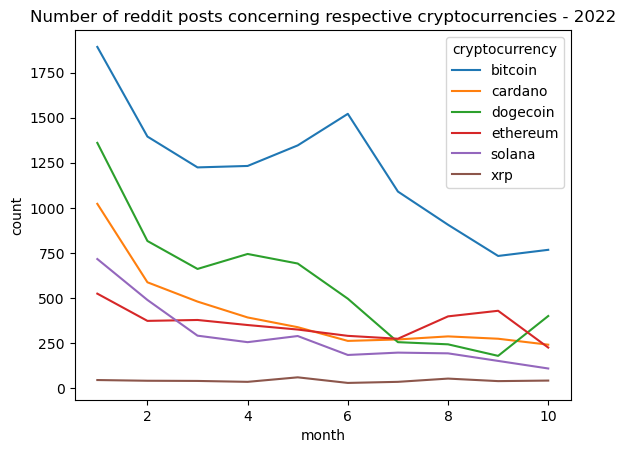

In [94]:
sns.lineplot(data=crypto_count_by_month,  x="month", y="count", hue="cryptocurrency").set(title='Number of reddit posts concerning respective cryptocurrencies - 2022')


### Grouped by day

In [99]:
crypto_count_by_month = data.groupby(["cryptocurrency", "day"]).count().reset_index().loc[:,["cryptocurrency", "day", "id"]]

crypto_count_by_month.columns = ["cryptocurrency", "day", "count"]


[Text(0.5, 1.0, 'Number of reddit posts concerning respective cryptocurrencies - 2022')]

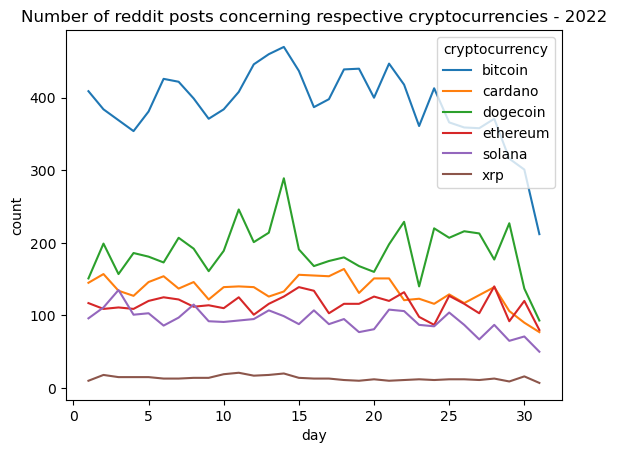

In [100]:
sns.lineplot(data=crypto_count_by_month,  x="day", y="count", hue="cryptocurrency").set(title='Number of reddit posts concerning respective cryptocurrencies - 2022')


### Grouped by hour

In [95]:
crypto_count_by_month = data.groupby(["cryptocurrency", "hour"]).count().reset_index().loc[:,["cryptocurrency", "hour", "id"]]

crypto_count_by_month.columns = ["cryptocurrency", "hour", "count"]


[Text(0.5, 1.0, 'Number of reddit posts concerning respective cryptocurrencies - 2022')]

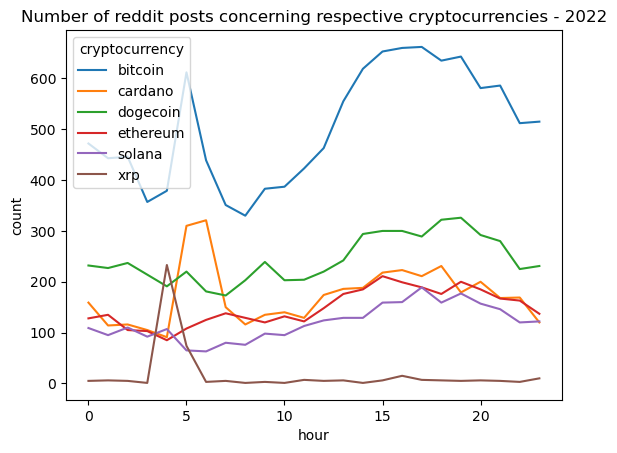

In [96]:
sns.lineplot(data=crypto_count_by_month,  x="hour", y="count", hue="cryptocurrency").set(title='Number of reddit posts concerning respective cryptocurrencies - 2022')


Cryptocurrency popularity is higher in early hours of each day and in the evening. Nevertheless, each cryptocurrency's **popularity decreased over time in 2022.**

# NLP related tasks - only attempts

In [58]:
from sparknlp.annotator import Lemmatizer, Stemmer, Tokenizer, Normalizer
from sparknlp.base import DocumentAssembler, Finisher

In [59]:
# Spark Pipelines allow us to sequentially add components such as transformers
from pyspark.ml import Pipeline

# These are components we will incorporate into our pipeline.
from pyspark.ml.feature import StopWordsRemover, CountVectorizer, IDF

In [60]:
from nltk.corpus import stopwords
eng_stopwords = stopwords.words('english')

In [61]:
# # https://codelabs.developers.google.com/codelabs/spark-nlp#7

# Now, we begin assembling our pipeline. Each component here is used to some transformation to the data.
# The Document Assembler takes the raw text data and convert it into a format that can
# be tokenized. It becomes one of spark-nlp native object types, the "Document".
document_assembler = DocumentAssembler().setInputCol("text").setOutputCol("document")

# The Tokenizer takes data that is of the "Document" type and tokenizes it.
# While slightly more involved than this, this is effectively taking a string and splitting
# it along ths spaces, so each word is its own string. The data then becomes the
# spark-nlp native type "Token".
tokenizer = Tokenizer().setInputCols(["document"]).setOutputCol("token")

# The Normalizer will group words together based on similar semantic meaning.
normalizer = Normalizer().setInputCols(["token"]).setOutputCol("normalizer")

# The Stemmer takes objects of class "Token" and converts the words into their
# root meaning. For instance, the words "cars", "cars'" and "car's" would all be replaced
# with the word "car".
stemmer = Stemmer().setInputCols(["normalizer"]).setOutputCol("stem")

# The Finisher signals to spark-nlp allows us to access the data outside of spark-nlp
# components. For instance, we can now feed the data into components from Spark MLlib.
finisher = Finisher().setInputCols(["stem"]).setOutputCols(["to_spark"]).setValueSplitSymbol(" ")

# Stopwords are common words that generally don't add much detail to the meaning
# of a body of text. In English, these are mostly "articles" such as the words "the"
# and "of".
stopword_remover = StopWordsRemover(inputCol="to_spark", outputCol="filtered")

# Here we implement TF-IDF as an input to our LDA model. CountVectorizer (TF) keeps track
# of the vocabulary that's being created so we can map our topics back to their
# corresponding words.
# TF (term frequency) creates a matrix that counts how many times each word in the
# vocabulary appears in each body of text. This then gives each word a weight based
# on its frequency.
tf = CountVectorizer(inputCol="filtered", outputCol="raw_features")

# Here we implement the IDF portion. IDF (Inverse document frequency) reduces
# the weights of commonly-appearing words.
idf = IDF(inputCol="raw_features", outputCol="features")

In [62]:
lda = LDA(k=10, maxIter=10)

# We add all of the transformers into a Pipeline object. Each transformer
# will execute in the ordered provided to the "stages" parameter
pipeline = Pipeline(
    stages = [
        document_assembler,
        tokenizer,
        normalizer,
        stemmer,
        finisher,
        stopword_remover,
        tf,
        idf,
        lda
    ]
)

In [65]:
text = df2.select("text").fillna("")

In [66]:
model = pipeline.fit(text)

23/01/02 01:07:19 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 121.0 (TID 115) (bda-hdfs-dataproc-new-w-1.europe-north1-b.c.crypto-busting.internal executor 3): java.lang.ClassCastException: cannot assign instance of java.lang.invoke.SerializedLambda to field org.apache.spark.sql.catalyst.expressions.objects.LambdaVariable.accessor of type scala.Function2 in instance of org.apache.spark.sql.catalyst.expressions.objects.LambdaVariable
	at java.io.ObjectStreamClass$FieldReflector.setObjFieldValues(ObjectStreamClass.java:2301)
	at java.io.ObjectStreamClass.setObjFieldValues(ObjectStreamClass.java:1431)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2437)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.j

Py4JJavaError: An error occurred while calling o382.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 121.0 failed 4 times, most recent failure: Lost task 0.3 in stage 121.0 (TID 121) (bda-hdfs-dataproc-new-w-1.europe-north1-b.c.crypto-busting.internal executor 3): java.lang.ClassCastException: cannot assign instance of java.lang.invoke.SerializedLambda to field org.apache.spark.sql.catalyst.expressions.objects.LambdaVariable.accessor of type scala.Function2 in instance of org.apache.spark.sql.catalyst.expressions.objects.LambdaVariable
	at java.io.ObjectStreamClass$FieldReflector.setObjFieldValues(ObjectStreamClass.java:2301)
	at java.io.ObjectStreamClass.setObjFieldValues(ObjectStreamClass.java:1431)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2437)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:503)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:461)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:527)
	at sun.reflect.GeneratedMethodAccessor9.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1184)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2322)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:503)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:461)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:527)
	at sun.reflect.GeneratedMethodAccessor9.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1184)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2322)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:503)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:461)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:527)
	at sun.reflect.GeneratedMethodAccessor9.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1184)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2322)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:503)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:461)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:527)
	at sun.reflect.GeneratedMethodAccessor9.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1184)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2322)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:503)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:461)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:527)
	at sun.reflect.GeneratedMethodAccessor9.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1184)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2322)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:503)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:461)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:527)
	at sun.reflect.GeneratedMethodAccessor9.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1184)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2322)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:503)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:461)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:527)
	at sun.reflect.GeneratedMethodAccessor9.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1184)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2322)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:503)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:461)
	at org.apache.spark.serializer.JavaDeserializationStream.readObject(JavaSerializer.scala:76)
	at org.apache.spark.serializer.JavaSerializerInstance.deserialize(JavaSerializer.scala:115)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:85)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:505)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:508)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2304)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2252)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2252)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1124)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1124)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1124)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2491)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2433)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2422)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:902)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2204)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2225)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2244)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2269)
	at org.apache.spark.rdd.RDD.count(RDD.scala:1253)
	at org.apache.spark.ml.feature.CountVectorizer.fit(CountVectorizer.scala:233)
	at org.apache.spark.ml.feature.CountVectorizer.fit(CountVectorizer.scala:149)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.ClassCastException: cannot assign instance of java.lang.invoke.SerializedLambda to field org.apache.spark.sql.catalyst.expressions.objects.LambdaVariable.accessor of type scala.Function2 in instance of org.apache.spark.sql.catalyst.expressions.objects.LambdaVariable
	at java.io.ObjectStreamClass$FieldReflector.setObjFieldValues(ObjectStreamClass.java:2301)
	at java.io.ObjectStreamClass.setObjFieldValues(ObjectStreamClass.java:1431)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2437)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:503)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:461)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:527)
	at sun.reflect.GeneratedMethodAccessor9.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1184)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2322)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:503)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:461)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:527)
	at sun.reflect.GeneratedMethodAccessor9.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1184)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2322)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:503)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:461)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:527)
	at sun.reflect.GeneratedMethodAccessor9.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1184)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2322)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:503)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:461)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:527)
	at sun.reflect.GeneratedMethodAccessor9.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1184)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2322)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:503)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:461)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:527)
	at sun.reflect.GeneratedMethodAccessor9.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1184)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2322)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:503)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:461)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:527)
	at sun.reflect.GeneratedMethodAccessor9.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1184)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2322)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:503)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:461)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:527)
	at sun.reflect.GeneratedMethodAccessor9.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1184)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2322)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:503)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:461)
	at org.apache.spark.serializer.JavaDeserializationStream.readObject(JavaSerializer.scala:76)
	at org.apache.spark.serializer.JavaSerializerInstance.deserialize(JavaSerializer.scala:115)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:85)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:505)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:508)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
